In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx
import itertools
import collections

%matplotlib notebook

In [25]:
class BS:
    def __init__(self, lattice, N, network, fitnesses=None):
        self.lattice = lattice
        self.N = N
        self.network = network
        self.node_idx = N
        
        # create graph
        if network[0] == "watts-strogatz":
            (_, k, p) = network
            self.g = nx.watts_strogatz_graph(N, k, p)
            
            if fitnesses is None:
                fitnesses = np.random.random(N)
            for node in self.g:
                self.g.nodes[node]["id"] = node
                self.g.nodes[node]["fitness"] = fitnesses[node]

        
        # relabel nodes
#         self.g = nx.relabel_nodes(self.g, mapping={i: start_idx+i for i in range(N)})
    
    def species(self):
        return dict(self.g.nodes.data("id")).values()
    
    def fitness(self):
        return self.g.nodes.data("fitness")
    
    def min_fitness(self):
        return min(self.fitness(), key=lambda x: x[1])
    
    def max_fitness(self):
        return max(self.fitness(), key=lambda x: x[1])
    
    def mutate(self):
        (i, f) = self.min_fitness()
        neighbours = list(self.g[i])
        
        # detect avalanches
#         if t == 0:
#             min_fitness = f[t,i]
#             av_size = 1
#         elif f[t,i] < min_fitness:
#             av_size += 1
#         else:
#             avs.append(av_size)
#             min_fitness = f[t,i]
#             av_size = 1
        
        self.g.node[i]["fitness"] = np.random.random()
        self.g.node[i]["id"] = self.lattice.species_idx
        self.lattice.species_idx += 1
        for nghbr in neighbours:
            self.g.node[nghbr]["fitness"] = np.random.random()
            self.g.node[nghbr]["id"] = self.lattice.species_idx
            self.lattice.species_idx += 1


In [33]:
class Lattice:
    def __init__(self, dimensions, N, network, P):
        self.dimensions = dimensions
        self.N = N
        self.P = P
        self.species_idx = np.prod(dimensions)*N
        
        # create lattice
        self.lattice = nx.grid_graph(list(dimensions), periodic=True)
        
        # create BS network in each point of the lattice
        fitnesses = np.random.random(N)
        for (i, point) in enumerate(self.lattice):
            self.lattice.node[point]["BS"] = BS(self, N, network, fitnesses=fitnesses)
            

    def __getitem__(self, i):
        return self.lattice.node[i]["BS"]
    
    def mean_species(self):
        ids = set()
        for i, point in enumerate(self.lattice):
            ids = ids.union(set(self[point].species()))
        return len(ids) / (i + 1)

    def run(self, t_max, t_mutate):
        for t in range(t_max):
            for point in self.lattice:
                bs = self[point]
                if t % t_mutate == 0:
                    bs.mutate()

                lattice_neighbours = list(self.lattice[point])
                
                # migration
                if np.random.random() < self.P:
                    migrate_to = lattice_neighbours[np.random.randint(0, len(lattice_neighbours))]
                    bs_target = self[migrate_to]
                    
                    migrator = -1
                    for nod_id, spec_id in np.random.permutation(bs.g.nodes.data("id")):
                        if spec_id not in bs_target.species():
                            migrator = nod_id
                            break
                    if migrator >= 0:
                        n1 = np.random.choice(bs_target.g.nodes)
                        n2 = np.random.choice(list(bs_target.g[n1]))

                        # TODO: werkt nu alleen voor ring networks
                        bs_target.g.add_node(bs_target.node_idx, **bs.g.node[migrator])
                        bs_target.g.remove_edge(n1, n2)
                        bs_target.g.add_edge(n1, bs_target.node_idx)
                        bs_target.g.add_edge(n2, bs_target.node_idx)
                        bs_target.node_idx += 1

                # extinction
                if np.random.random() < self.P * len(bs.g.nodes)/self.N:
                    x = np.random.choice(list(bs.g.nodes))

                    neighbours = list(bs.g[x])
                    edges = list(itertools.combinations(neighbours, 2))

                    bs.g.remove_node(x)
                    bs.g.add_edges_from(edges)
    
    def draw(self):
        nx.draw(self.lattice, with_labels=True)
        
    def nr_species(self):
        nr = np.empty(self.dimensions)
        for i in range(self.dimensions[0]):
            for j in range(self.dimensions[1]):
                nr[i, j] = len(self[(i,j)].species())
                
        return nr
    

            
    def area_curve(self, sampling_scheme='quadrats', log=True):
        # sampling_scheme = ['nested'|'quadrats']
        fig, ax = plt.subplots()

        if sampling_scheme == 'nested':
            area_curve = np.empty((self.dimensions[0],2))
            for s in range(1, self.dimensions[0]+1):
                species = set()
                for i in range(0, s):
                    for j in range(0, s):
                        species = species.union(self[(i,j)].species())

                nr = len(species)
                print(np.sum(self.nr_species()[:s,:s]), nr)
                area_curve[s-1] = (s**2, nr)
            print(area_curve)
            ax.plot(*area_curve.T, "o")

        elif sampling_scheme == 'quadrats':
            area_curve = collections.OrderedDict()
            for grain_size in range(1, max(self.dimensions)+1):
                assert self.dimensions[0] == self.dimensions[1]
                means = []
                for interval_i in range(0, self.dimensions[0], grain_size):
                    for interval_j in range(0, self.dimensions[1], grain_size):
                        species = set()
                        for i,j in np.ndindex((grain_size,grain_size)):
                            ii = interval_i * grain_size + i
                            jj = interval_j * grain_size + j
                            species = species.union(self[(i,j)].species())

                        means.append(len(species))

                area_curve[grain_size**2] = np.mean(means)
                print('grain size: %i, mean: %0.3f'% (grain_size, np.mean(means)))
            ax.scatter(list(area_curve.keys()), list(area_curve.values()))
        
        ax.set_xlabel("Area")
        ax.set_ylabel("Number of species")
        
        if log:
            ax.set_xscale("log")
            ax.set_yscale("log")
            
        power = (np.log10(area_curve[self.dimensions[0]**2]) - np.log10(area_curve[1])) / (np.log10(self.dimensions[0]**2) - np.log10(1))
        print("power: {}".format(power))
    

CPU times: user 2min 47s, sys: 80.6 ms, total: 2min 47s
Wall time: 2min 46s


<IPython.core.display.Javascript object>


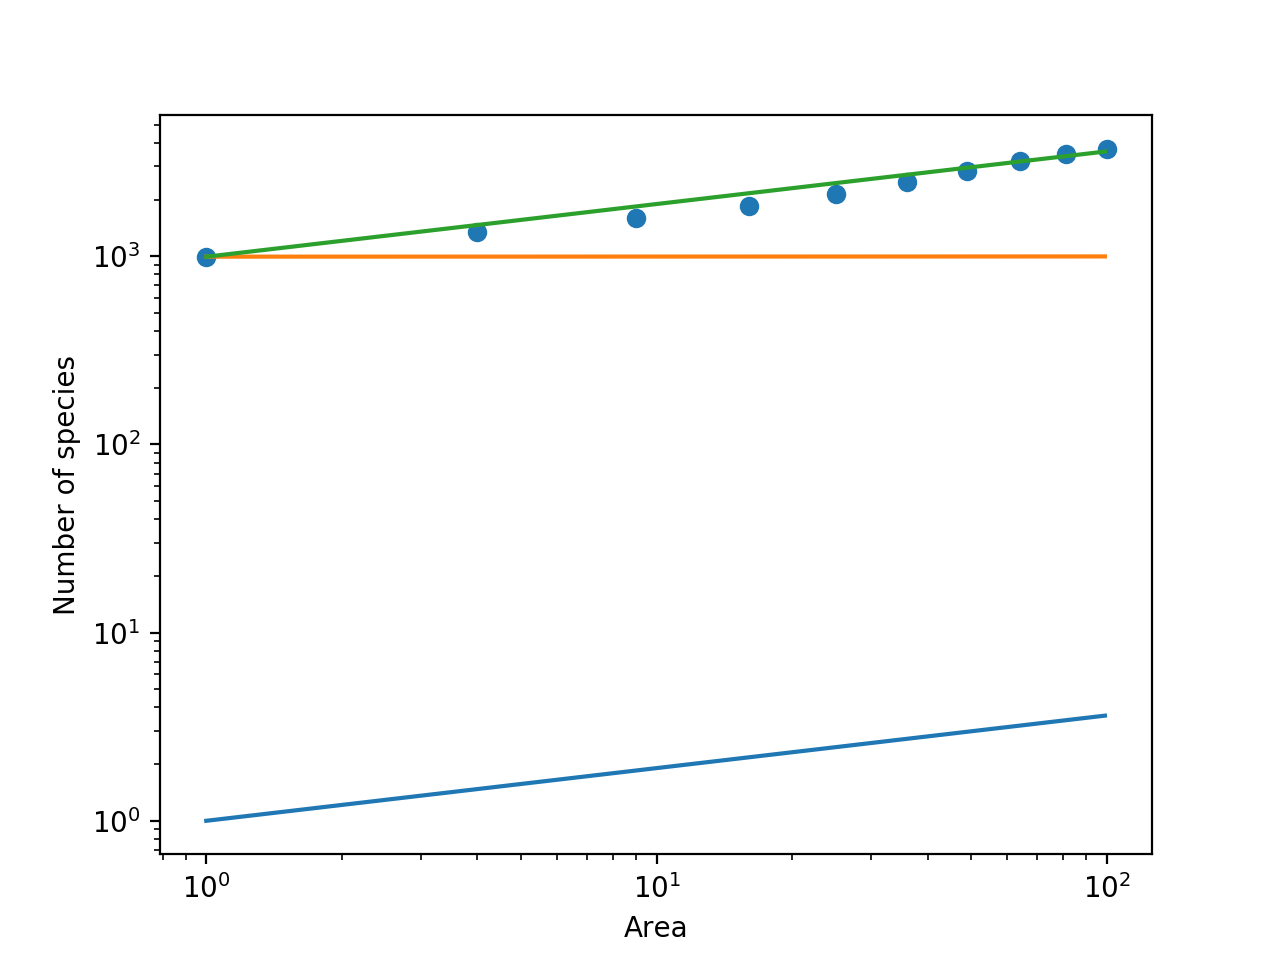

grain size: 1, mean: 994.000
grain size: 2, mean: 1346.000
grain size: 3, mean: 1587.000
grain size: 4, mean: 1843.000
grain size: 5, mean: 2144.000
grain size: 6, mean: 2478.000
grain size: 7, mean: 2844.000
grain size: 8, mean: 3200.000
grain size: 9, mean: 3499.000
grain size: 10, mean: 3723.000
0.2867533259105395


In [35]:
l = Lattice((10,10), 1000, ("watts-strogatz", 3, 0), 0.5)
%time l.run(1000, 100)

l.area_curve("quadrats")

In [38]:
x = np.arange(1, 100)
plt.plot(x, 994*x**0.28)

<IPython.core.display.Javascript object>


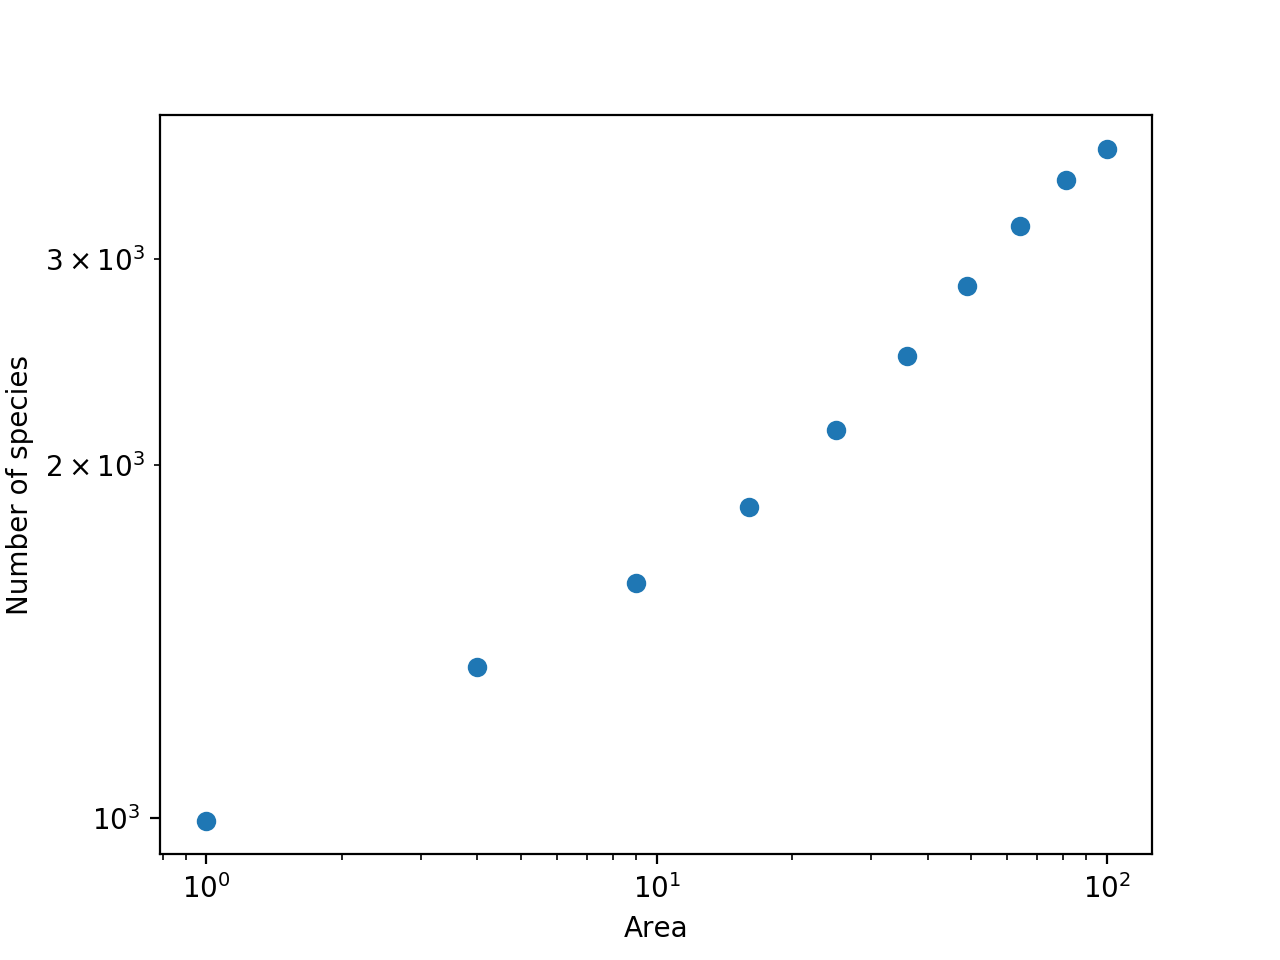

grain size: 1, mean: 994.000
grain size: 2, mean: 1346.000
grain size: 3, mean: 1587.000
grain size: 4, mean: 1843.000
grain size: 5, mean: 2144.000
grain size: 6, mean: 2478.000
grain size: 7, mean: 2844.000
grain size: 8, mean: 3200.000
grain size: 9, mean: 3499.000
grain size: 10, mean: 3723.000
0.2867533259105395


In [39]:
# l = Lattice((10,10), 1000, ("watts-strogatz", 3, 0), 0.5)
# %time l.run(1000, 200)

l.area_curve("quadrats")

<IPython.core.display.Javascript object>


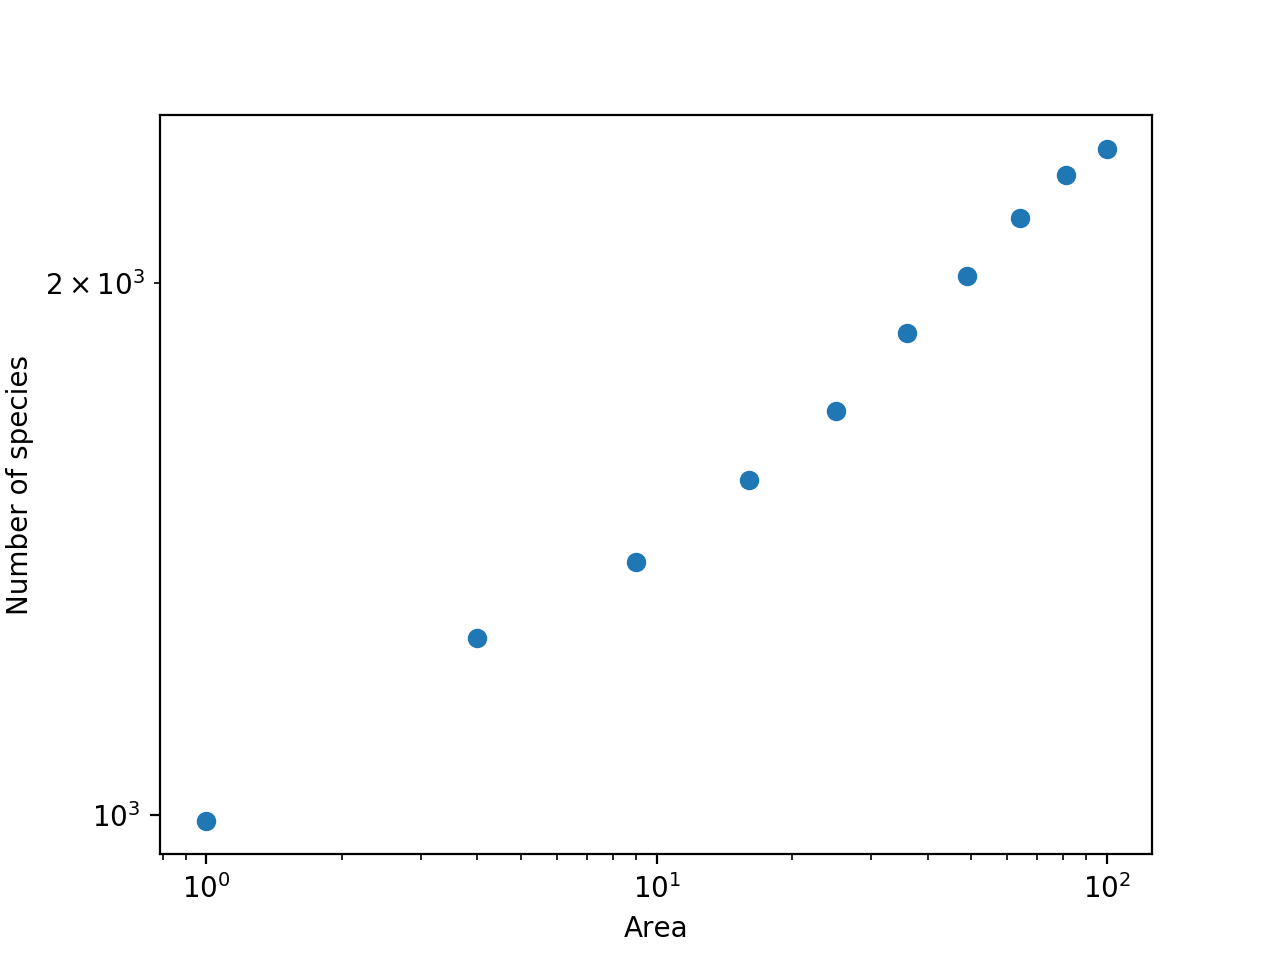

grain size: 1, mean: 993.000
grain size: 2, mean: 1260.000
grain size: 3, mean: 1391.000
grain size: 4, mean: 1548.000
grain size: 5, mean: 1692.000
grain size: 6, mean: 1873.000
grain size: 7, mean: 2017.000
grain size: 8, mean: 2175.000
grain size: 9, mean: 2302.000
grain size: 10, mean: 2381.000


In [32]:
l.area_curve("quadrats", log=True)

<IPython.core.display.Javascript object>


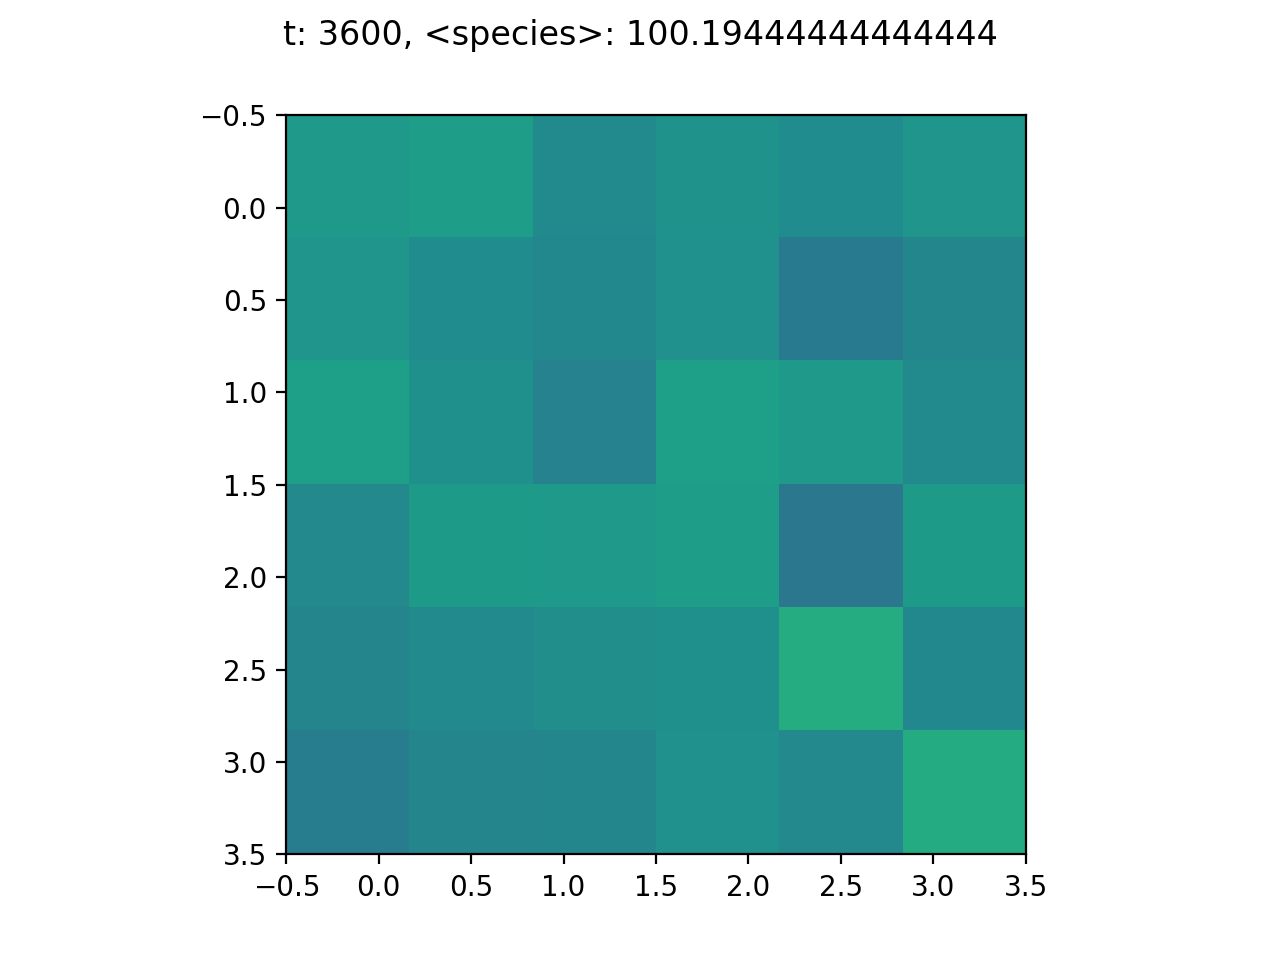

In [54]:
np.random.seed(0)
l = Lattice((6,6), 100, ("watts-strogatz", 3, 0), 0.1)


nr_species = np.zeros((4,4))

fig = plt.figure()
im = plt.imshow(nr_species, vmin=0, vmax=200)

def init():
     pass

def animate(i):
    l.run(1000, 10)
    
    fig.suptitle("t: {}, <species>: {}".format((i+1) * 100, np.mean(l.nr_species())))
    im.set_data(l.nr_species())
    
    return im 

ani = animation.FuncAnimation(fig, animate, np.arange(100), init_func=init, interval=100, repeat=False, blit=True, save_count=1000)

<IPython.core.display.Javascript object>


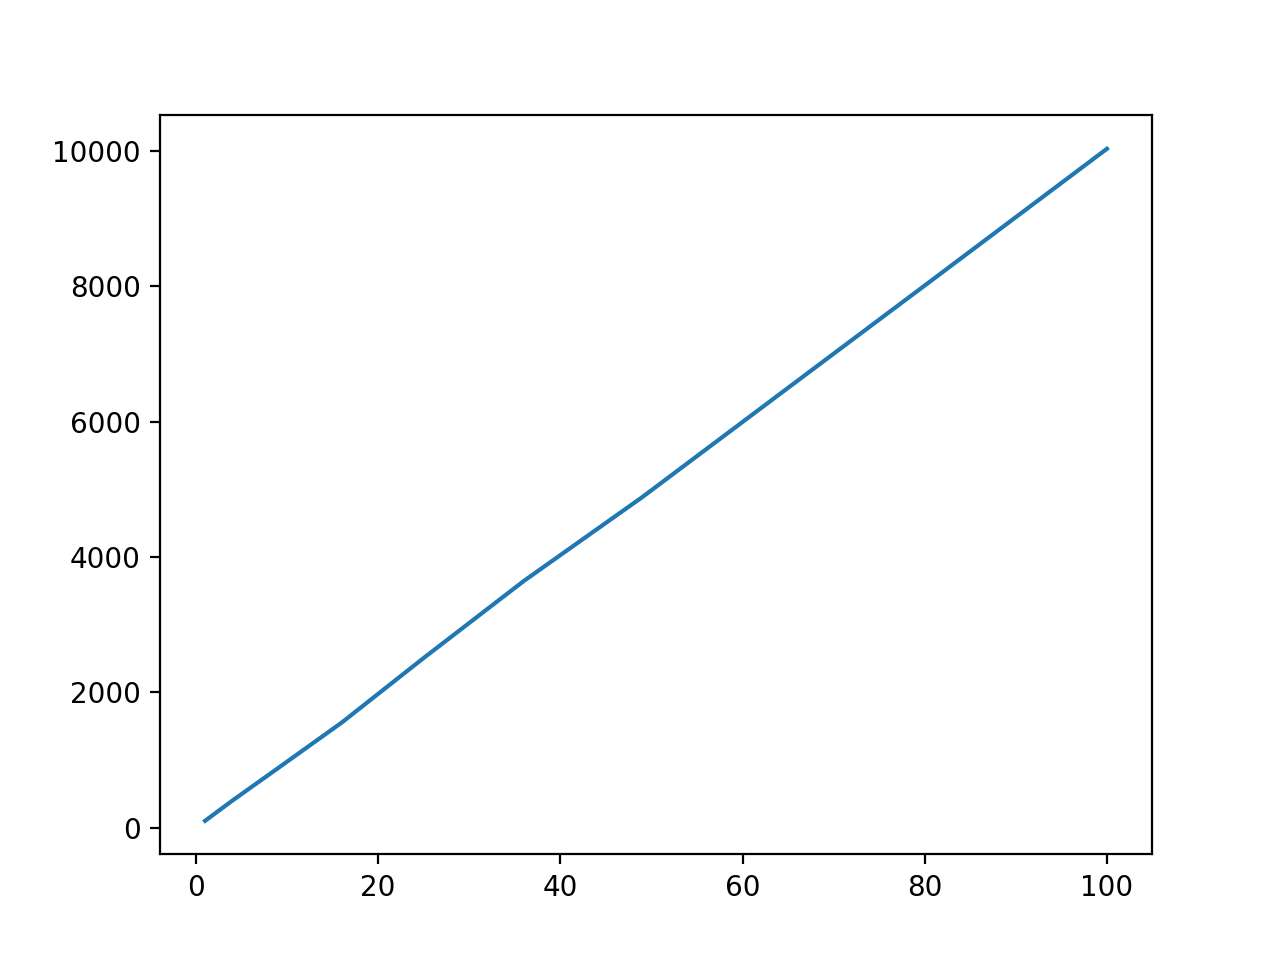

[[1.0000e+00 1.0000e+02]
 [4.0000e+00 3.9900e+02]
 [9.0000e+00 8.7800e+02]
 [1.6000e+01 1.5520e+03]
 [2.5000e+01 2.5070e+03]
 [3.6000e+01 3.6460e+03]
 [4.9000e+01 4.8850e+03]
 [6.4000e+01 6.3990e+03]
 [8.1000e+01 8.1130e+03]
 [1.0000e+02 1.0033e+04]]


In [37]:
l.area_curve()

In [145]:
N_lattice = 4
N_species = 100
t_max = 100000
P_migration = 0.01

g = nx.grid_graph([N_lattice, N_lattice], periodic=False)
g = nx.convert_node_labels_to_integers(g)

fig, ax = plt.subplots()
nx.draw(g, with_labels=True)

# create BS networks
idx_node = 0
idx = 0
for node in g.nodes():
    g_species = nx.watts_strogatz_graph(N_species, 3, 0)
    
    for species in g_species:
        g_species.node[species]["id"] = idx
        g_species.node[species]["fitness"] = np.random.random()
        idx += 1
        
    g.nodes[node]["BS"] = nx.relabel_nodes(g_species, mapping={i: idx_node+i for i in range(N_species)})
    idx_node += N_species
    

    
# perform Bak-Sneppen
for t in range(t_max-1):
        
    for node in g.nodes():
        lattice_neighbours = list(g[node])    
   
        bs = g.node[node]["BS"]
        fs = nx.get_node_attributes(bs, "fitness").values()
        
        i = np.argmin(list(fs))
        i = list(nx.get_node_attributes(bs, "fitness").keys())[i]
        nghbrs = list(bs[i])
        
#         if t == 0:
#             min_fitness = f[t,i]
#             av_size = 1
#         elif f[t,i] < min_fitness:
#             av_size += 1
#         else:
#             avs.append(av_size)
#             min_fitness = f[t,i]
#             av_size = 1

        bs.node[i]["id"] = idx
        idx += 1
        bs.node[i]["fitness"] = np.random.random()
        for nghbr in nghbrs:
            bs.node[nghbr]["fitness"] = np.random.random()
            bs.node[nghbr]["id"] = idx
            idx += 1
            
            
#         age[t+1] = age[t] + 1
#         age[t+1, i] = 0
#         age[t+1, idx] = 0

        # migration
        if np.random.random() < P_migration:
            migrate_to = np.random.choice(lattice_neighbours)
            target = g.node[migrate_to]["BS"]
            
            migrator = np.random.choice(bs.nodes)
            
            n1 = np.random.choice(target.nodes)
            n2 = np.random.choice(list(target[n1]))
            
            target.add_node(idx_node, attr=bs.node[migrator])
            target.remove_edge(n1, n2)
            target.add_edge(n1, idx_node)
            target.add_edge(n2, idx_node)
            idx_node += 1
            
        # extinction
        if np.random.random() < P_migration:
            x = np.random.choice(bs.nodes)
            
            nghbrs = list(bs[x])
            edges = list(itertools.combinations(nghbrs, 2))
            
            bs.remove_node(x)
            bs.add_edges_from(edges)

<IPython.core.display.Javascript object>

KeyError: 0

In [8]:
g.node[0]["BS"].nodes

NodeView((1, 8, 31, 33, 34, 46, 57, 62, 66, 72, 80, 86, 91, 94, 98, 1662, 1682, 1698, 1752, 1756, 1760, 1918, 2060, 2100, 2146, 2184, 2372, 2382, 2442, 2596, 2705, 2784, 2806, 2848, 2858, 3007, 3113, 3126, 3145))

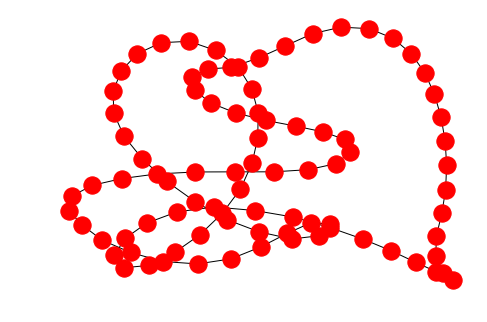

In [9]:
nx.draw(g.node[3]["BS"])

In [10]:
nr_species = [len(g.node[i]["BS"].nodes) for i in g.nodes()]
print(nr_species)
print(np.mean(nr_species))

[39, 113, 111, 87, 126, 118, 120, 107, 93, 122, 136, 143, 57, 104, 112, 68]
103.5


In [11]:
np.argmin(list(nx.get_node_attributes(g.node[1]["BS"], "fitness").values()))

14

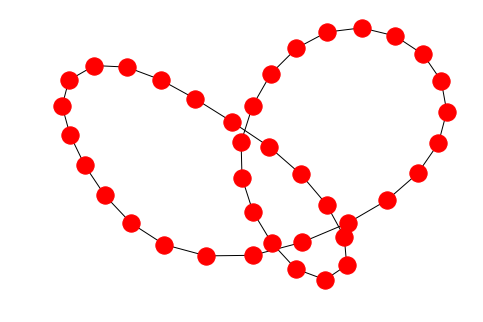

In [12]:
nx.draw(g.nodes[0]["BS"])